DQ_birthdates_advanced_stats_v1.0.ipynb

**Analysis approach of the data quality of dates using z-score (with Python)**

As a continuation of the article *Analysis approach of the data quality of dates using basic statistical methods (with Python)*, we are going to use z-score, a statistical calculation based on the standard deviation.

**Z-score**
After importing and exploring the dates of birth dataset (from the article related) we need to transform all dates to numbers (dates to simple number and dates to ages from now).
Please note that we have previously reported a potential issue with the date 01/01/2000 (mm/dd/YYYY) possibly due to a technical error or the use of the date as a dummy date, so we will remove again these dates for this analysis.

In [ ]:
import pandas as pd
from datetime import date

def years_from_now(d):
    today = d.today()
    age = today.year - d.year - ((today.month, today.day) < (d.month, d.day))
 
    return age

#Import dataset dates from github
url = "https://raw.githubusercontent.com/mabrotons/datasets/master/birthdates.csv"


df = pd.read_csv(url, index_col=0, parse_dates=['birthdates'])

#transforming dates in numbers
df['birthdates_num'] = [int(d.strftime("%Y%m%d")) for d in df['birthdates']] 
df = df.loc[df['birthdates_num'] != 20000101]

#transforming dates in ages old
df['ages'] = [years_from_now(d) for d in df['birthdates']] 

We will build a couple of plots to represent birthdates, in order to have a first view of the dataset. As the plots show, the data represented is identical in both plots (symmetrically), and we have to decide which date format will be most useful for analysis.

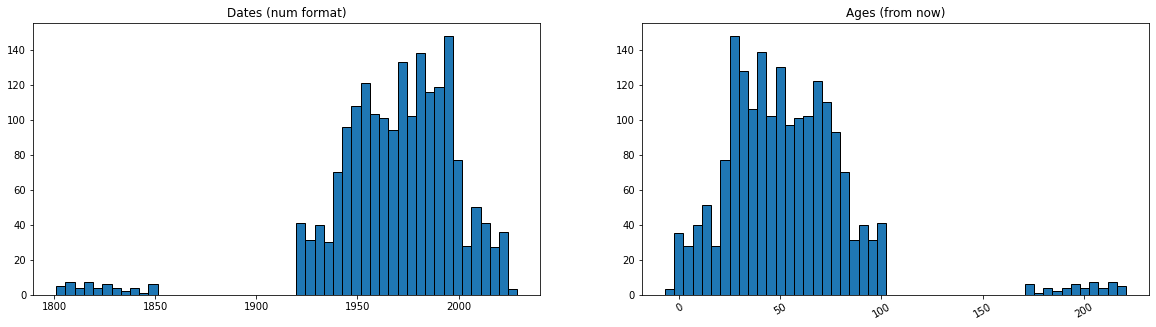

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import ticker

fig, axes =plt.subplots(1, 2, figsize=(20,5))

dates_num = df['birthdates_num']
ages = df['ages']

axes[0].hist(dates_num, bins=50, edgecolor='black')
axes[1].hist(ages, bins=50, edgecolor='black')
plt.xticks(rotation=30)

#formating the xticks labels (year) for first subplot()
axes[0].xaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos: format(x/10000,'1.0f')))
axes[0].title.set_text('Dates (num format)')
axes[1].title.set_text('Ages (from now)')

plt.show()

Now it's time to start the calculation of standard deviation to know how values are distributed around all dataset, and detect possible outliers: candidates to be outliers will be multiple standard-deviations far from the mean.
As we can see with means and standard deviations calculated, it's easier to work with dates transformed to ages than to simple number.

In [ ]:
std_birthdates_num = df['birthdates_num'].std()
mean_birthdates_num = df['birthdates_num'].mean()
print("Mean of birthdates_num: " + str(mean_birthdates_num))
print("Standard deviation of birthdates_num: " + str(std_birthdates_num))

std_ages = df['ages'].std()
mean_ages = df['ages'].mean()
print("\nMean deviation of ages: " + str(mean_ages))
print("Standard deviation of ages: " + str(std_ages))

Mean of birthdates_num: 19681984.715186547
Standard deviation of birthdates_num: 336693.98125531274

Mean deviation of ages: 53.895953757225435
Standard deviation of ages: 33.67419358794017


Now, selecting ages transformed like esay way, let's calculate z-score:

z = (x – μ) / σ

where Z is the score, x is the value to calculate the score, μ is the mean and σ is the standard deviation.
The z-score is a calculation that measure how many standard deviations a value is far away from the mean, and the probability of data to be unusual in a distribution.
It's recomended to use z-score with a normal distribution, because in a normal distribution over 99% of values fall within 3 standard deviations from the mean. For that, we can assume:
- if a z-score returned is lower than 1 shoud be a normal data value
- if a z-score returned is larger than 1 and lower than 3, could be an error
- if a z-score returned is larger than 3 should be an error

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


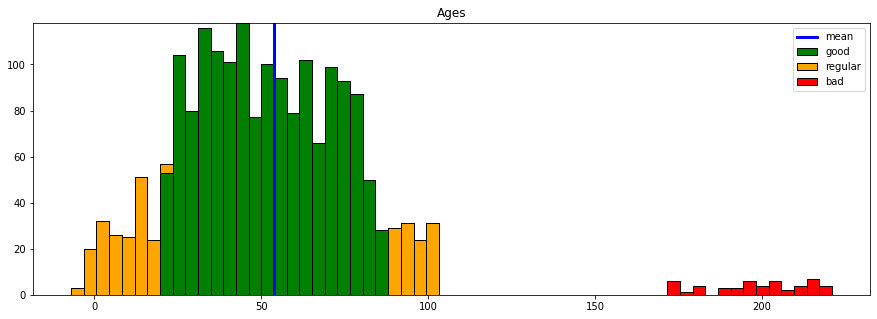

In [ ]:
df['zscore'] = [(a-mean_ages)/std_ages for a in df['ages']] 

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(5)

good_ages = df.loc[(df['zscore'] <= 1) & (df['zscore'] >= -1)]['ages']
regular_ages = df.loc[((df['zscore'] > 1) & (df['zscore'] <= 3)) | ((df['zscore'] < -1) & (df['zscore'] >= -3))]['ages']
bad_ages = df.loc[(df['zscore'] > 3) | (df['zscore'] < -3)]['ages']

plt.hist([good_ages, regular_ages ,bad_ages], color=['Green', 'Orange', 'Red'], label=['good', 'regular', 'bad'], edgecolor='black', bins=60, histtype='barstacked')

#add vertical line at mean value of x
plt.axvline(x=mean_ages, color='blue', linewidth=3, label='mean')

plt.title("Ages")
plt.legend()
plt.show()

Another way to calculate z-score is with scipy.stats funtion:
import scipy.stats as stats
df['zscore'] = stats.zscore(df['ages'])

Now, we can print to ten ouliers detected with a z-score by both ends.

In [ ]:
sorted_df =  df.sort_values('zscore')
print("Top 10 left: ")
print(sorted_df.head(10))

print("\nTop 10 right: ")
print(sorted_df.tail(10))

Top 10 left: 
              ids birthdates  birthdates_num  ages    zscore
1902  C0000001903 2029-10-15        20291015    -7 -1.808386
1901  C0000001902 2029-01-21        20290121    -7 -1.808386
1900  C0000001901 2028-03-10        20280310    -6 -1.778690
1540  C0000001541 2024-09-23        20240923    -2 -1.659905
1284  C0000001285 2024-10-27        20241027    -2 -1.659905
1028  C0000001029 2023-04-13        20230413    -1 -1.630208
1564  C0000001565 2023-03-03        20230303    -1 -1.630208
1675  C0000001676 2023-03-22        20230322    -1 -1.630208
1703  C0000001704 2023-05-27        20230527    -1 -1.630208
1667  C0000001668 2023-11-21        20231121    -1 -1.630208

Top 10 right: 
              ids birthdates  birthdates_num  ages    zscore
1894  C0000001895 1808-10-03        18081003   214  4.754503
1859  C0000001860 1808-04-01        18080401   214  4.754503
1856  C0000001857 1807-01-19        18070119   215  4.784199
1857  C0000001858 1806-01-10        18060110   216  4.8

**Isolation Forest**

IsolationForest is an unsupervised learning algorithm that identifies possible anomalies by isolating outliers in a dataset. Its calculation is inspired by the Random Forest classification and regression algorithm.

Firstly, we are going to define and fit the model. We have to instance IsolationForest with the next three parameters:
- n_estimators: number of base estimators or trees in the ensemble. It's optional and the default value is 100.
- max_samples: number of samples used to train each base estimator. The default value of max_samples is 'auto', max_samples=min(256, n_samples).
- contamination: expected proportion of outliers in the dataset. The default value is 'auto', determined as in the original paper of Isolation Forest.


In [ ]:
from sklearn.ensemble import IsolationForest
import numpy as np

model = IsolationForest(n_estimators = 1000, max_samples = 'auto', contamination=float(0.1))
print(model.get_params())

model.fit(df[['ages']])

{'bootstrap': False, 'contamination': 0.1, 'max_features': 1.0, 'max_samples': 'auto', 'n_estimators': 1000, 'n_jobs': None, 'random_state': None, 'verbose': 0, 'warm_start': False}


/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.1, n_estimators=1000)

After the model is defined and fitted, it will show the IsolationForest instance result as shown in the output.

Now, we will create two new columns with decision function and predict information:

- decision_function(). Average anomaly score of X of the base classifiers.
- predict(). Predict if a particular sample is an outlier or not.

To show results in a plot we have to split the ages with anomaly_score criteria.

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3208: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).size
/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


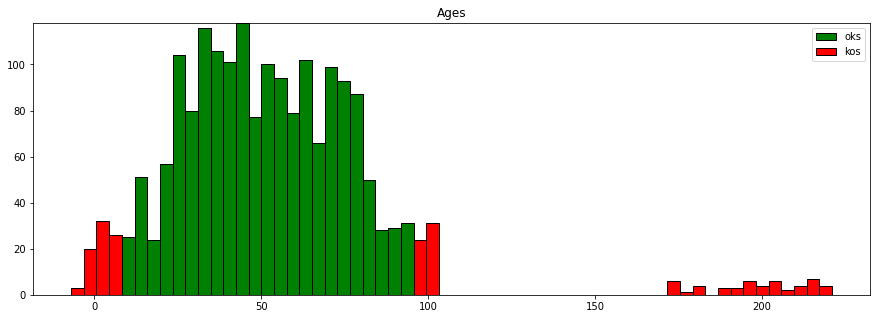

In [ ]:
df['scores'] = model.decision_function(df[['ages']])
df['anomaly_score'] = model.predict(df[['ages']])

ok = df[df['anomaly_score']==1]
ko = df[df['anomaly_score']==-1]

f = plt.figure()
f.set_figwidth(15)
f.set_figheight(5)

plt.hist([ok['ages'], ko['ages']], color=['Green', 'Red'], label=['oks', 'kos'], edgecolor='black', bins=60, histtype='barstacked')

plt.title("Ages")
plt.legend()
plt.show()

Now, we can print top ten ouliers detected with a Isolation Forest algorithm, agreed with the maximum obtained with z-score.

In [ ]:
sorted_df =  df.sort_values('scores')
print("Top 10 left: ")
print(sorted_df.head(10))

Top 10 left: 
              ids birthdates  birthdates_num  ages    zscore    scores  \
1898  C0000001899 1801-09-03        18010903   221  4.962377 -0.206648   
1860  C0000001861 1801-12-29        18011229   221  4.962377 -0.206648   
1873  C0000001874 1802-11-22        18021122   220  4.932681 -0.204303   
1851  C0000001852 1803-04-27        18030427   219  4.902984 -0.201246   
1891  C0000001892 1805-01-28        18050128   217  4.843592 -0.195308   
1857  C0000001858 1806-01-10        18060110   216  4.813895 -0.192998   
1893  C0000001894 1806-12-10        18061210   216  4.813895 -0.192998   
1856  C0000001857 1807-01-19        18070119   215  4.784199 -0.189079   
1877  C0000001878 1849-05-16        18490516   173  3.536953 -0.186404   
1865  C0000001866 1849-08-14        18490814   173  3.536953 -0.186404   

      anomaly_score  
1898             -1  
1860             -1  
1873             -1  
1851             -1  
1891             -1  
1857             -1  
1893             

**Conclusion**

With z-score and Isolation Forest algorithm are two easy ways to identify possible anomalies in a dataset, through the use of scores for each of the data and through its visualization.